In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

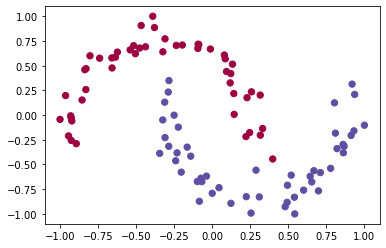

In [2]:
n_samples = 100

X, y = make_moons(n_samples=n_samples, noise=0.1)
scaler = MinMaxScaler((-1, 1))
X = scaler.fit_transform(X)

# plot the dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [24]:
# Separate X_train data based on labels in y_train
X_train_A = X_train[y_train == 0]
X_train_B = X_train[y_train == 1]

# Separate X_test data based on labels in y_test
X_test_A = X_test[y_test == 0]
X_test_B = X_test[y_test == 1]

# Combine the separated data into single NumPy arrays for X_train, y_train, X_test, and y_test
X_train_np = np.vstack((X_train_A, X_train_B))
y_train_np = np.hstack((np.zeros(len(X_train_A)), np.ones(len(X_train_B))))

X_test_np = np.vstack((X_test_A, X_test_B))
y_test_np = np.hstack((np.zeros(len(X_test_A)), np.ones(len(X_test_B))))

## Variational Quantum Classifier

In [84]:
from qiskit_machine_learning.algorithms import VQC
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap

In [19]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
optimizer = SPSA(maxiter=40)
var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=3)
num_qubits = 2
vqc = VQC(num_qubits, 
        feature_map, 
        ansatz = var_form, 
        loss = 'cross_entropy',
        optimizer = optimizer, 
)

In [25]:
vqc.fit(X_train_np, y_train_np)

In [26]:
test_accuracy = vqc.score(X_test_np, y_test_np)
print(f'Testing success ratio: {test_accuracy}')

Testing success ratio: 0.5333333333333333


## Quantum Support Vector Machine

In [ ]:
from qiskit_machine_learning.algorithms import QSVC

In [87]:
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

In [88]:
# Initialize the quantum kernel
kernel = QuantumKernel(feature_map=ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear'))


In [89]:
qsvc = QSVC(quantum_kernel=kernel)

In [91]:
# fit the model
qsvc.fit(X_train, y_train)

QiskitMachineLearningError: 'A QuantumInstance or Backend must be supplied to evaluate a quantum kernel.'